In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from sklearn.preprocessing import normalize

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy

### Import LDA document vectors

In [4]:
#tfidf_matrix = np.load(open("../processed_files/tfidf_matrix.npy"))
tfidf_matrix = scipy.sparse.load_npz('../../processed_files/tfidf_matrix.npz')
df_merged = pickle.load(open("../../processed_files/df_merged.pickle", "rb"))

In [5]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[0, -, m, y, ., c, o, m, , r, e, l, a, t, e, ..."
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[0, 1, 1, 8, 7, ., c, o, m, , i, s, , a, v, ..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[0, 2, 7, ., i, r, , -, , d, n, s, 4, ., i, ..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[f, e, b, r, u, a, r, y, , |, , 2, 0, 1, 4, ..."


In [6]:
df_merged.shape

(12975, 4)

In [7]:
print(tfidf_matrix.shape)
print(tfidf_matrix[0].shape)

(12968, 272069)
(1, 272069)


## tfidf

In [8]:
#from sklearn.preprocessing import normalize
#tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1)

In [10]:
tfidf_matrix.shape

(12968, 272069)

In [11]:
tfidf_matrix[0].shape

(1, 272069)

In [9]:
new_tfidf_matrix = tfidf_matrix / np.linalg.norm(tfidf_matrix)

ValueError: dimension mismatch

In [26]:
new_tfidf_matrix = tfidf_matrix.todense() / np.linalg.norm(tfidf_matrix.todense())

In [12]:
%%time
nbrs = NearestNeighbors(n_neighbors = 10, algorithm = 'ball_tree').fit(tfidf_matrix)
distances, indices = nbrs.kneighbors(tfidf_matrix)

/Users/dkarsann/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_base.py:462: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


CPU times: user 30.1 s, sys: 6.77 s, total: 36.9 s
Wall time: 38 s


In [61]:
print(distances.shape)
print(indices.shape)

(12956, 20)
(12956, 20)


In [62]:
distances[0]

array([0.        , 0.        , 0.4460879 , 0.49713873, 0.55559218,
       0.56599868, 0.59746107, 0.74252772, 0.76912187, 0.77833471,
       0.78997678, 0.80890761, 0.80933426, 0.80933426, 0.80933426,
       0.80933426, 0.80933426, 0.80933426, 0.80933426, 0.80933426])

In [63]:
indices[0]

array([    0,   160,  6206,  6387,  1160,   166,  1694,  4272,  5568,
        5742,   139,  2575,  8471,  7384,  7410, 12188,  3646,  5564,
       10781,  2072])

In [76]:
import statistics

def intracluster_similarity(index):
    cluster_centroid = tfidf_matrix[index]
    dist_list = []
    for i in indices[index][1:]:
        distance = np.linalg.norm(cluster_centroid.toarray()-tfidf_matrix[i].toarray())
        dist_list.append(distance)
        #print(index, ',', i, '=', distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)
    
    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    #print('variance:', variance)
    
    return avg, variance

In [77]:
intracluster_similarity(1234)

(1.2348086215729488, 0.002008545107742311)

In [55]:
def generate_raw_content_cluster_df(index):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})
    #return combined

In [66]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(64)

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PARSED,DISTANCE
64,1stlincslimo.co.uk,"1st lincs limo & wedding cars | lincolnshire prom limousine hire lincolnshire prom limousine hire home now booking 2021 2022 wedding car hire and 2020 2021 prom car hire, prom limo hire. tel 01522595236 or 07702693448 tel 01522595236 or 07702693448 here at 1st lincs limo & wedding cars we have been offering luxury car hire in lincoln and the lincolnshire area since 2000, we have limousine covering wedding car and wedding limousines hire. prom limo hire lincoln lincolnshire, we still have some availability for 2020 prom limousine hire. tel 01522595236 – 07702693448 party limo hire lincolnshire wedding cars, 2020 and 2021/2 lincoln wedding car bookings now being taken with just a £130 deposit/booking fee your lincolnshire luxury wedding transport can be secured today. we have a range of classic 1920’s style car and modern saloons. lincoln registry office wedding, lincoln church wedding, civil wedding cars all on offer from 1st lincs limo & wedding cars please call for lincoln wedding car packages. tel 01522595236 – 07702693448 stag and hen parties in lincoln with anything from 1 hour’s limo hire,restaurant hen party with transport there and back or a limousine to a lincoln nightclub and back. lincoln kids parties and kids limo party’s with 1st lincs limo in a fun and safe environment. tel 01522595236 – 07702693448 social","st lincs limo & wedding cars | lincolnshire prom limousine hire lincolnshire prom limousine hire home now booking wedding car hire and prom car hire, prom limo hire. tel or tel or here at st lincs limo & wedding cars we have been offering luxury car hire in lincoln and the lincolnshire area since , we have limousine covering wedding car and wedding limousines hire. prom limo hire lincoln lincolnshire, we still have some availability for prom limousine hire. tel – party limo hire lincolnshire wedding cars, and / lincoln wedding car bookings now being taken with just a £ deposit/booking fee your lincolnshire luxury wedding transport can be secured today. we have a range of classic ’s style car and modern saloons. lincoln registry office wedding, lincoln church wedding, civil wedding cars all on offer from st lincs limo & wedding cars please call for lincoln wedding car packages. tel – stag and hen parties in lincoln with anything from hour’s limo hire,restaurant hen party with transport there and back or a limousine to a lincoln nightclub and back. lincoln kids parties and kids limo party’s with st lincs limo in a fun and safe environment. tel – social",0
6455,knightservice.net,knight's services limo llc,knight's services limo llc,1.1784
4300,follettphotography.com.au,"highly recommended gold coast wedding photographer search for: gold coast wedding photographer2020-07-01t14:40:54+10:00 gold coast wedding photographeri am a wedding photographer. yes, i am based on the gold coast, but i travel between byron bay to brisbane and, well, all around australia and the world to capture beautiful wedding stories.every minute of your wedding day is worth cherishing, so i want to make sure as much as possible is documented for you. your wedding day should be re-lived over and over! that is why i include the very highest quality wedding albums in my packages. i envision each of my clients sitting down in 20-30 years, using their wedding album to help plan the wedding of their children. i started only as a gold coast wedding photographer but now also photograph beautiful wedding stories in brisbane, sunshine coast, byron bay, hawaii, fiji, new zealand … well anywhere in the world really… so no matter where your wedding, give me a call! but how do you even choose a wedding photographer? before you even start to look for a wedding photographer, you should think of how much you value your wedding images. what style are you attracted to? what specially do you want out of your experience? then, start the journey of finding a photographer with the style and per

In [101]:
avg_list = []
variance_list = []

for i in range(tfidf_matrix.shape[0]):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x132a5a3c8>,
 <a list of 11 Text xticklabel objects>)

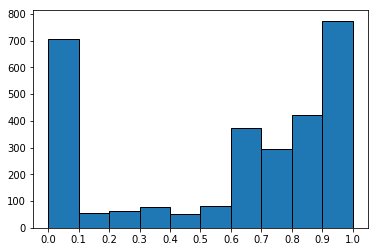

In [102]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x127eb3ba8>,
 <a list of 11 Text xticklabel objects>)

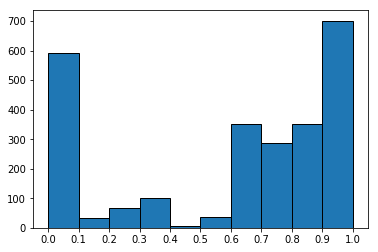

In [79]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x137254908>,
 <a list of 11 Text xticklabel objects>)

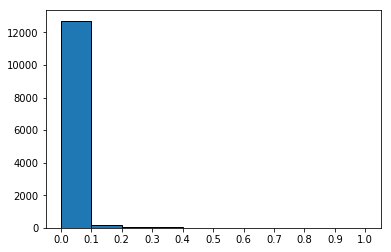

In [103]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x133727d30>,
 <a list of 11 Text xticklabel objects>)

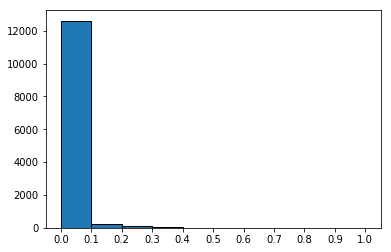

In [80]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [81]:
print(len(avg_list), len(variance_list))

12956 12956


## Intercluster Similarity

In [82]:
def calculate_centroid(index):
    cluster_centroid = tfidf_matrix[index]
    for i in indices[index][1:]:
        cluster_centroid = np.add(cluster_centroid, tfidf_matrix[i])
    return cluster_centroid/len(indices[index][1:])

In [104]:
index_centroid = dict()
for i in range(tfidf_matrix.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [86]:
index_centroid[0]

<1x182058 sparse matrix of type '<class 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [24]:
#centroid_centroid_distance = {}
#for i in range(tfidf_matrix.shape[0]):
#    centroid_centroid_distance[i] = {}
#    for j in range(tfidf_matrix.shape[0]):
#        if i < j:
#            centroid_centroid_distance[i][j] = np.linalg.norm(index_centroid[i]-index_centroid[j])

In [25]:
#centroid_centroid_distance

In [92]:
from random import sample
def sample_mean_intercluster_dist(sample_size):
    indices_sample = sample(range(tfidf_matrix.shape[0]),sample_size)
    centroid_centroid_distance = {}
    for i in indices_sample:
        for j in indices_sample:
            if i < j:
                key = str(i) + "::" + str(j)
                centroid_centroid_distance[key] = np.linalg.norm(index_centroid[i].toarray()-index_centroid[j].toarray())
    return np.array(list(centroid_centroid_distance.values())).mean()

# neighbors = 10

## 10 documents sample

In [105]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[1.0265882660850332, 0.8893661258181672, 0.9221959795016821, 0.991759429592663, 1.0456249348921955]

0.9751069471779482


## 100 documents sample

In [106]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.9427808675433548, 0.9863879483761095, 0.921370224692027, 0.9858748839241905, 1.0308106594184985]

0.9734449167908361


## 500 documents sample

In [107]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.9944982252883817, 0.9853412022084705, 0.9864363061508223, 0.9986238729540432, 0.9875694061293777]

0.990493802546219


# neighbors = 20

## 10 documents sample

In [96]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.7005023728264059, 0.6648928706198498, 0.6822978329784922, 0.9462235648251783, 0.7249165514962914]

0.7437666385492436


## 100 documents sample

In [97]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.8126034462496546, 0.8468211359616783, 0.8086582894775923, 0.8214938757484384, 0.8255235574439705]

0.8230200609762669


## 500 documents sample

In [98]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.8266176600737934, 0.8439198960262345, 0.8290923575993873, 0.8305318532592579, 0.8356948282647645]

0.8331713190446877
